## Preparation

With the code below, we ensure that we are constantly updating the local packages while importing them in the jupyter notebook environment

In [45]:
%load_ext autoreload
%autoreload 2
%aimport

import matplotlib.pyplot as plt
import torch
import numpy as np
from inverse_optim import gen_data
from inverse_optim import research_plot
from inverse_optim import sancho
import tadasets
import gudhi as gd
import powerbox as pbox

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



# Circle and the Figure Eight

First, choose which figure you would like to generate. You can comment out the figure you are not interested in.

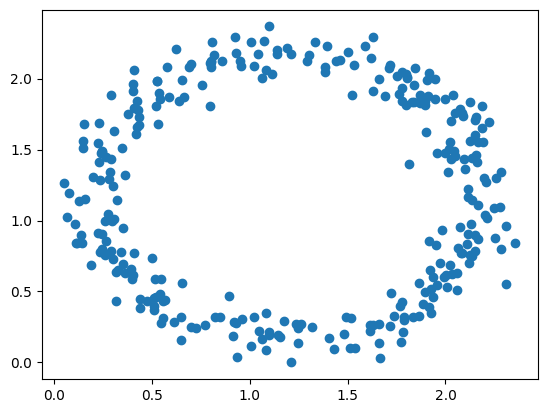

In [46]:
# This is a synthetic data set that we want "approximate"
N = 300
goal_pts = tadasets.dsphere(n=N, d=1, noise=0.1) # circle
# goal_pts = tadasets.infty_sign(n=N, noise=0.1) # figure eight

# Translate whole point set so that nothing is negative
min_coord = np.min(goal_pts)
goal_pts = goal_pts - min_coord

# Find box_size
box_size = np.max(goal_pts)

# To perform Stochastic Gradient Descent (SGD), we need our set to be of tensor type
goal_pts = torch.tensor(goal_pts)

# Plot the initial/goal data set
P = goal_pts.detach().numpy()
plt.scatter(P[:, 0], P[:, 1])
plt.show()

## Ripser Filtration

### Creation of dataset

For optimization purposes, we are interested in the pairwise distances of all the points. 

In the Rips filtration, we are constantly looking at sub-complexes of the largest possible complex given a dataset. The interesting parts of the filtration (that capture the persistent features) happen at a stage that is in the beginning before the total complex is reached. So if we are interested in optimizing the filtration, we could put a threshold on the possible edge lengths that are drawn without losing (too much) information.

To that end we will look at the pairwise distances of all points in the initial/goal point cloud and then determine what the 60-90th percentile is. It could be argued that for higher dimensional PD's, the persistence happens at later stages in general, meaning you would need a higher percentile. 

A guideline that is currently used (based on clinical estimations of a few trials and input of other postdocs/phds who are working with this project):
- Zero dimensional PD: 70
- One dimensional PD: 80
- Two dimensional PD: 90



In [3]:
from scipy.spatial.distance import cdist

# Initialize percentile
percentile = 80

# Creation of list of all pairwise distances
goal_D = cdist(goal_pts, goal_pts)
distance_vec = goal_D.flatten()

# Define maximum edge length
max_edge_length = np.percentile(distance_vec, percentile)

In [17]:
# Creation of the PD that we want to get to
goal_pd = gen_data.create_rips_pd(pts=goal_pts, max_edge_length=max_edge_length)

First, we need to find out what optimal learning rate is. If you would like to make the computation quicker (which will make it less accurate), pass the option sliced=True to use the sliced wasserstein distance as the metric. Warning: This is extremely slow compared to the other filtrations.

In [ ]:
lr_list = np.linspace(0.001, 1, 6)
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=N, dim=2, epochs=300, decay_speed=30, sliced=False, filtr="rips", max_edge_length=max_edge_length, box_size=box_size)

After running the above code, plug in the best learning rate:

In [ ]:
# Generation of new dataset
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=N, dim=2, lr=0.08, epochs=600, decay_speed=30, investigate=False, sliced=False, filtr="rips", box_size=box_size)

### The powerspectrum

In [ ]:
original_pts = goal_pts.detach().numpy()
produced_pts = final_pts.detach().numpy()

In [ ]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(original_pts, 2.0, N=N)
p_k_samples_new, bins_samples_new = pbox.get_power(produced_pts, 8.0, N=N)

In [ ]:
plt.plot(bins_samples, p_k_samples,label="Original Circle Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Circle Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')

## Alpha DTM Filtration

### Creation of dataset

In [49]:
# Creation of the PD that we want to get to
goal_pd = gen_data.create_hybrid_dtm_pd(goal_pts)

First, we need to find out what optimal learning rate is. If you would like to make the computation quicker (which will make it less accurate), pass the option sliced=True to use the sliced wasserstein distance as the metric.

Note: It seems like setting `m=0.7` and `p=1.5` give a circle without any stray points inside the circle.

In [ ]:
lr_list = np.linspace(0.1, 0.2, 6)
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=N, dim=2, epochs=300, decay_speed=30, sliced=0.5, filtr="alpha_dtm", box_size=box_size)

After running the above code, plug in the best learning rate:

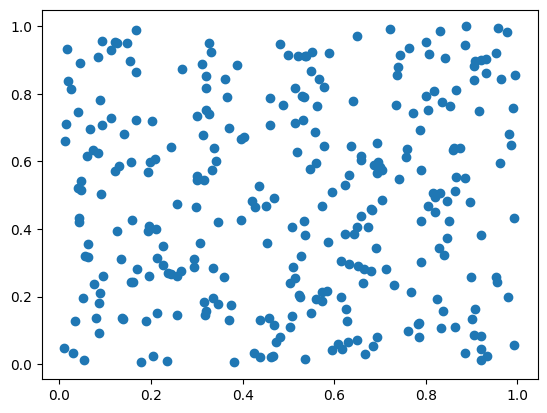

 16%|█▌        | 95/600 [00:02<00:11, 43.15it/s]

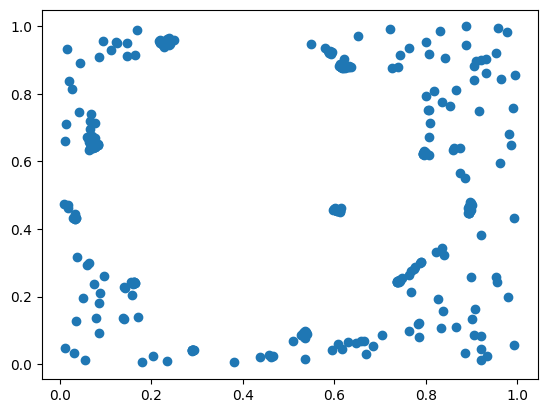

 33%|███▎      | 199/600 [00:04<00:08, 46.16it/s]

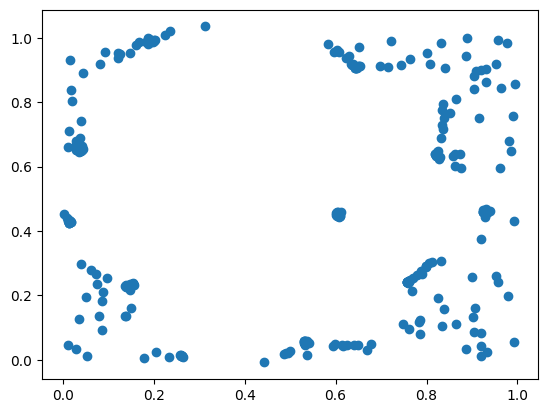

 50%|████▉     | 298/600 [00:07<00:08, 37.67it/s]

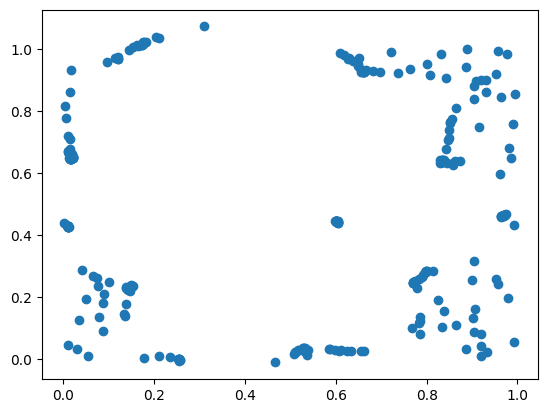

 66%|██████▌   | 397/600 [00:10<00:05, 34.12it/s]

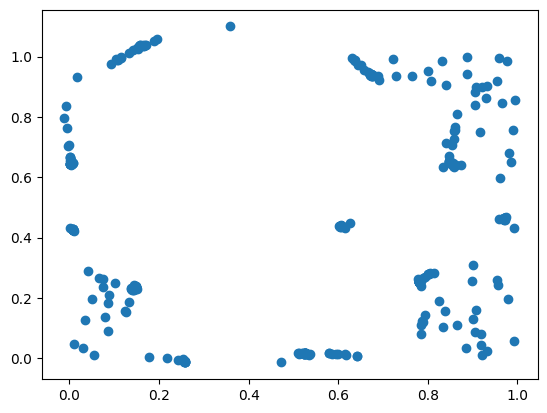

 83%|████████▎ | 498/600 [00:13<00:02, 36.52it/s]

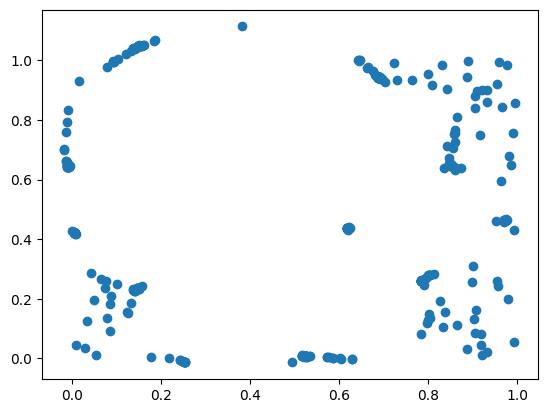

 99%|█████████▉| 596/600 [00:16<00:00, 36.38it/s]

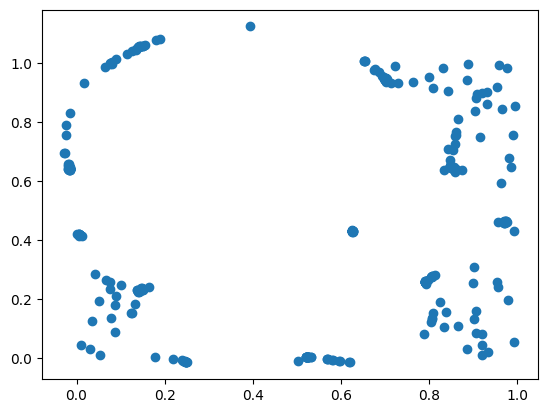

100%|██████████| 600/600 [00:16<00:00, 35.49it/s]


In [56]:
# Generation of new dataset
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=N, dim=2, lr=0.12, epochs=600, decay_speed=30, investigate=False, sliced=0.5, filtr="alpha_dtm")

### The powerspectrum

In [ ]:
original_pts = goal_pts.detach().numpy()
produced_pts = final_pts.detach().numpy()

In [ ]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(original_pts, 2.0, N=N)
p_k_samples_new, bins_samples_new = pbox.get_power(produced_pts, 8.0, N=N)

In [ ]:
plt.plot(bins_samples, p_k_samples,label="Original Circle Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Circle Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')

## Alpha-Ripser Hybrid Filtration

### Creation of the new dataset

In [13]:
# Creation of the PD that we want to get to
goal_pd = gen_data.create_hybrid_pd(goal_pts)

First, we need to find out what optimal learning rate is. If you would like to make the computation quicker (which will make it less accurate), pass the option sliced=True to use the sliced wasserstein distance as the metric.

In [31]:
lr_list = np.linspace(0.001, 0.2, 6)
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=N, dim=2, epochs=300, decay_speed=30, sliced=False, filtr="alpha_rips_hybrid")

  1%|          | 2/300 [00:00<00:23, 12.57it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  1%|▏         | 4/300 [00:00<00:22, 12.90it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  3%|▎         | 8/300 [00:00<00:22, 12.74it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  3%|▎         | 10/300 [00:00<00:22, 12.99it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  5%|▍         | 14/300 [00:01<00:22, 12.49it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  5%|▌         | 16/300 [00:01<00:22, 12.54it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  6%|▋         | 19/300 [00:01<00:22, 12.74it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


KeyboardInterrupt: 

After running the above code, plug in the best learning rate:

In [ ]:
# Generation of new dataset
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=N, dim=2, lr=0.08, epochs=600, decay_speed=30, investigate=False, sliced=False, filtr="alpha_rips_hybrid")

### The powerspectrum

In [ ]:
original_pts = goal_pts.detach().numpy()
produced_pts = final_pts.detach().numpy()

In [ ]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(original_pts, 2.0, N=N)
p_k_samples_new, bins_samples_new = pbox.get_power(produced_pts, 8.0, N=N)

In [ ]:
plt.plot(bins_samples, p_k_samples,label="Original Circle Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Circle Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')

# Sancho

In [ ]:
# Load dataset
cat = np.load(f'/Users/sliemela/Downloads/Sancho/fiducial_HOD_fid_NFW_sample0_1Gpc_z0.50_RSD3_run0.npz')
pos = cat['pos']        # shape: (N_galaxies, 3) --> X,Y,Z position of each galaxy in Mpc/h
vel = cat['vel']        # shape: (N_galaxies, 3) --> Vx, Vy, Vz velocity of the galaxy in km/s
gtype = cat['gtype']

# Split up the dataset
split = (2,2,2)
bins = sancho.bin(pos, split)

# Plotting the bins
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for x in bins:
    if len(x) != 0:
        ax.scatter3D(x[:, 0], x[:, 1], x[:, 2])

In [ ]:
# Calculating the statistics of the wasserstein distances of sancho
list_of_wasser_dist = sancho.compare_wasser_alpha(bins)

wasser_mean = np.mean(list_of_wasser_dist)
wasser_std = np.std(list_of_wasser_dist)

print(wasser_mean)
print(wasser_std)

# NOTE: the code of compare_wasser_alpha has been changed to only consider the first 3000. In the future, we may consider all pairs. 